# Импорты

Импорт всех необходимых библиотек

In [2]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
#from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [6]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [8]:
%pip install -q boruta


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [10]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

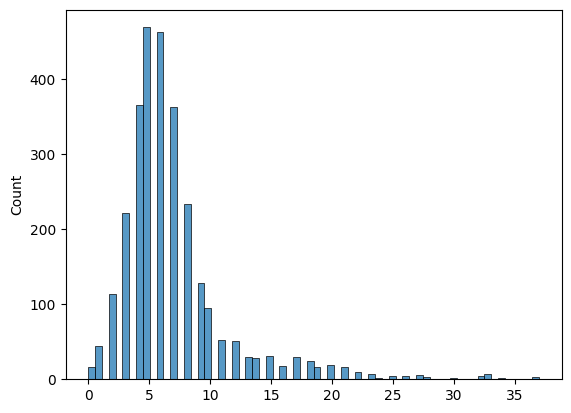

In [11]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [12]:
df = df.drop(df[df['bmi']>80].index)

In [13]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

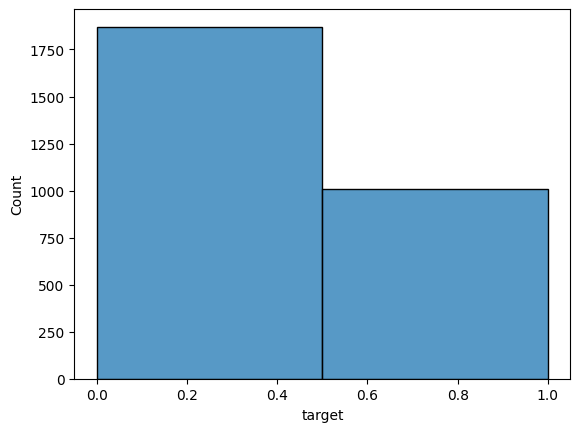

In [14]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [15]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

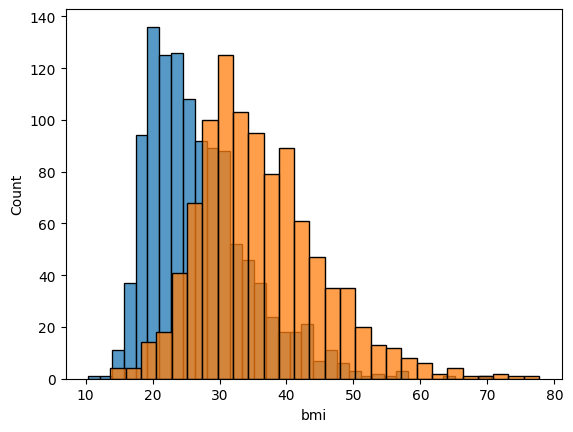

In [16]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [17]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
1929,NaN,2.3,NaN,333.42,32.86,2070.55,74.42,1825.64,1456.78,18.92,19.59,72.69,2.79,2.03,14.68,24.49,2694.23,10.76,1.17,99.75,689.34,10.98,0.15,42.48,1.80,148.00,18.36,304.46,5.28,1109.72,0.90,1.62,2.95,1.16,209.49,2.27,155.04,199.02,0.02,3.10,1111.51,0.73,0.00,0.91,11.51,11.53,0.02,1.47,115.50,1.73,0.90,0.47,21.88,NaN,1.78,3.22,NaN,3.04,12.04,1.58,6.86,14.35,2.38,1.02,16.00,30.18,53.46,89.64,11.58,7.24,1,0,0,1,25.802003,0
1281,NaN,NaN,NaN,245.44,21.77,1513.18,50.82,1079.89,651.93,6.47,7.29,40.36,1.45,1.26,7.73,9.12,1204.35,23.36,0.72,55.98,429.24,NaN,0.40,5.00,1.08,107.52,6.26,121.55,1.90,352.55,0.60,0.76,1.57,0.71,128.79,2.09,87.71,211.00,NaN,1.85,639.24,0.93,0.02,0.61,6.43,2.87,0.01,0.95,32.64,1.03,0.47,0.30,5.39,NaN,1.00,0.39,NaN,1.77,7.75,0.88,44.71,1.84,1.33,0.39,2.34,4.91,40.24,22.29,1.80,3.74,1,0,1,0,28.719723,0
545,NaN,NaN,NaN,392.47,19.62,947.90,126.00,1643.15,1670.70,8.26,8.95,62.68,2.41,1.99,10.65,14.65,2470.55,21.43,1.10,56.25,765.45,2.06,NaN,30.89,1.74,220.98,8.13,231.22,3.94,272.02,1.00,1.43,3.13,1.32,220.56,3.56,87.97,66.34,NaN,2.98,1018.84,1.14,NaN,0.98,10.20,5.07,0.00,1.49,83.72,1.60,0.64,0.43,8.48,NaN,1.60,3.32,NaN,2.90,12.47,2.57,2.45,4.08,2.09,0.74,5.95,14.62,61.47,80.60,4.43,6.57,0,1,0,1,29.745809,0
2093,NaN,NaN,NaN,551.78,31.93,2523.56,68.01,1672.63,1375.57,16.89,16.68,88.92,4.06,3.36,16.33,15.15,3039.09,11.33,1.85,87.89,713.24,2.51,0.15,24.75,2.96,148.78,14.59,260.34,8.59,724.75,1.21,1.89,5.62,1.61,294.42,3.19,217.92,190.17,NaN,4.85,1249.11,1.24,0.01,1.62,14.44,7.38,0.01,2.45,196.50,2.70,1.47,0.73,9.14,NaN,2.66,2.73,16.0,4.72,18.42,6.59,99.95,15.04,2.24,1.01,12.50,19.44,91.69,97.90,14.40,9.04,0,0,0,0,28.027682,0
732,NaN,NaN,NaN,169.51,19.73,1075.93,109.83,1336.02,762.99,10.82,4.80,35.60,0.86,0.65,7.59,5.02,1574.88,59.95,0.41,50.51,426.35,NaN,2.40,8.50,0.60,195.45,3.22,168.81,5.64,194.27,0.68,0.75,1.23,0.66,108.70,1.48,22.76,NaN,NaN,0.98,553.92,0.90,0.06,0.35,8.21,4.09,NaN,0.50,73.12,0.55,0.12,0.15,4.62,37.30,0.51,0.92,NaN,0.98,8.90,94.51,44.19,3.26,2.50,0.36,6.16,16.22,20.29,14.08,4.44,2.39,0,0,0,0,27.099251,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,NaN,63.3,NaN,376.42,25.13,1450.20,27.19,1521.97,740.33,9.77,15.02,55.36,2.60,2.06,11.17,19.67,1687.40,23.64,1.17,74.88,479.55,31.62,NaN,20.50,1.82,96.29,13.44,194.05,2.42,429.13,0.69,1.21,2.83,1.02,154.28,3.21,159.84,NaN,NaN,3.18,920.70,1.41,0.02,0.97,8.76,6.84,0.03,1.51,47.70,1.67,1.04,0.48,16.31,37.05,1.78,2.18,NaN,3.07,9.63,121.67,92.42,6.68,2.53,0.80,7.05,13.00,69.73,68.53,5.22,6.53,1,0,1,0,31.542857,1
630,NaN,64.5,NaN,752.47,44.44,7444.67,91.15,4183.52,2054.93,49.24,48.34,214.93,9.17,7.88,40.69,28.72,7509.42,35.94,4.54,159.04,1182.90,10.20,NaN,55.00,6.96,456.33,44.17,661.34,30.75,505.46,4.02,3.65,11.27,5.16,750.89,13.69,154.98,NaN,NaN,12.22,2954.81,8.32,NaN,3.97,41.59,34.46,0.02,6.12,152.70,6.49,0.46,1.84,7.21,NaN,6.56,4.50,NaN,11.61,61.63,20.00,15.00,

In [18]:
#df_train = df.drop(df_test.index)

In [19]:
#x_train = df_train.drop(columns=['target'])
#y_train = df_train['target']

In [20]:
#x_test = df_test.drop(columns=['target'])
#y_test = df_test['target']

In [21]:
df_temp = df.drop(df_test.index)
x_temp = df_temp.drop(columns=['target'])
y_temp = df_temp['target']
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [22]:
column_names = x_train.columns

In [23]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_val = pd.DataFrame(scaler.transform(x_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [24]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [25]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_val = x_val.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,-0.865927,-0.867949,-0.601639,-0.686210,-0.776509,-1.192126,-0.604692,-0.707510,-0.835924,-0.794409,-0.773987,-0.868755,-0.624082,-0.857305,-0.413372,-0.760386,-0.901716,-0.872127,-0.344521,-0.191182,-0.335236,-0.772318,-0.540857,-0.686506,-0.779192,-0.776634,-0.682998,-0.443479,-0.866082,-0.551150,-0.714433,-0.481565,-0.615200,-0.778820,-0.762210,NaN,-0.759340,-0.876560,-0.438303,-0.235900,-0.766042,-0.701808,-0.603171,-0.232713,-0.756879,-0.798078,-0.791569,-0.360818,-0.765001,-0.715467,NaN,-0.767954,-0.254227,NaN,-0.771996,-0.512428,-0.553386,-0.647194,-0.701983,-0.616529,-0.689002,-0.947239,-0.897024,-0.575026,-0.750342,-0.935455,-0.619402,1.084227,-0.277637,-0.461064,1.458124,-0.548003
1,NaN,NaN,NaN,-0.412106,-0.007677,-0.302062,-0.266866,-0.255826,0.307147,-0.436374,-0.061245,-0.306018,0.053402,0.000065,-0.392730,-0.208251,-0.266290,-0.274366,0.176852,0.094194,-0.113991,-0.045152,-0.148034,-0.115411,0.012352,-0.476866,-0.036978,-0.279245,-0.135404,-0.019207,-0.321234,-0.146323,-0.463555,-0.364725,-0.739728,0.063176,-0.161880,-0.199656,-0.376455,0.010410,-0.216363,-0.579065,-0.235900,0.088075,-0.385051,-0.003555,-0.383443,0.023725,-0.622164,0.071175,-0.153025,-0.031098,-0.147175,-0.769377,-0.033698,-0.218963,0.926105,0.041132,-0.187262,-0.516561,0.062477,-0.436667,-0.377691,-0.111920,-0.450275,-0.268724,-0.218106,0.318332,-0.398931,0.286008,-0.922316,3.601827,-0.461064,1.458124,-0.007372
2,NaN,-0.086654,NaN,0.391111,1.837776,-0.198197,1.707975,0.870297,0.909532,0.841822,0.607558,0.891133,0.699818,0.676832,0.443124,0.241737,0.751123,-0.133177,0.670511,1.041764,0.882656,-0.344936,-0.165293,0.193498,0.643916,0.713454,0.563635,0.691145,0.419241,1.181900,0.663518,0.981547,0.179646,0.706254,0.714565,0.730750,0.407195,-0.160210,-0.140620,0.646773,0.970806,0.534237,NaN,0.657486,0.515066,-0.233353,-0.383443,0.599207,1.338429,0.775664,0.007848,0.592720,0.195333,-0.141070,0.669750,0.222507,0.336840,0.641641,0.500098,2.795717,1.209120,0.213952,0.912443,0.579060,0.636601,0.426069,0.166573,-0.198553,0.633396,0.647233,1.084227,-0.277637,-0.461064,1.458124,1.826875
3,NaN,NaN,NaN,-0.709648,-0.926882,-0.939876,-0.863461,-1.090266,-1.383450,-0.953718,-0.889911,-1.062794,-0.999053,-1.027774,-1.139377,-0.810215,-1.139513,-0.495174,-1.003638,-1.018022,-0.877762,NaN,NaN,-0.345726,-1.021116,-1.015019,-0.871354,-1.048702,-0.791692,-0.853469,-0.952833,-1.118368,-0.976614,-1.173424,-1.245643,-0.857168,-0.817321,-0.575123,NaN,-1.020555,-1.083290,-0.943768,NaN,-0.964473,-1.047600,-0.758840,NaN,-1.007584,-0.931649,-1.021294,-0.290437,-1.040215,-0.769702,-0.404930,-1.055494,-0.269404,NaN,-1.024842,-1.176898,-0.468688,-0.672125,-0.649398,-0.845161,-0.969950,-0.847424,-0.814019,-1.040727,-0.847190,-0.864728,-1.018157,-0.922316,-0.277637,-0.461064,-0.685813,NaN
4,NaN,NaN,NaN,0.259665,0.089062,0.117795,0.312555,0.166444,-0.059495,0.124973,-0.217439,-0.082713,-0.297416,-0.232573,0.012078,-0.064195,-0.068228,0.428959,-0.173718,0.049015,0.340566,-0.238788,NaN,-0.225174,-0.241230,0.364552,-0.189976,-0.062843,-0.305436,0.523196,0.201703,0.016922,-0.035588,0.035982,0.080503,0.486621,0.027877,0.361690,-0.394596,-0.223016,

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков ADD-DEL

In [26]:
sfs = SequentialFeatureSelector(
    XGBClassifier(),  # represents the classifier
    k_features=5,
    forward=True,
    floating=True,
    scoring="f1_macro",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sfs.fit(x_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_...
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=None, ...),
                          floating=True, k_features=(5, 5), scoring='f1_macro')

In [27]:
df_temp = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
features_add_del = list(df_temp["feature_idx"].values[-1])
features_add_del

[35, 42, 50, 70, 74]

Для дальнейшей работы возьмем данные 5 наиболее значимых признаков.

In [28]:
x_train_add_del = x_train.iloc[:,features_add_del]
x_test_add_del = x_test.iloc[:,features_add_del]
x_test_add_del.columns

Index(['b12_кобаламин', 'лактоза', 'd',
       'профессия_работники_преимущественно_умственного_труда', 'bmi'],
      dtype='object')

<Axes: ylabel='Count'>

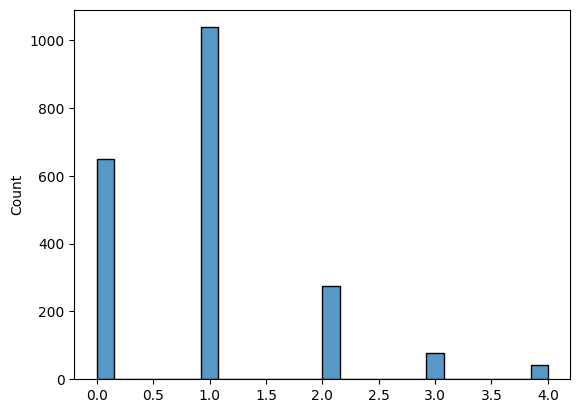

In [29]:
missing_features_add_del = x_train_add_del.isnull().sum(axis=1)
sns.histplot(missing_features_add_del)

## Отбор признаков Boruta

In [30]:
from boruta import BorutaPy

In [31]:
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

In [32]:
it_imp = IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [33]:
model = XGBClassifier()
feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)
feat_selector.fit(x_train_imp, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None, predictor=None,
                                 random_state=150087192, ...),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7F1E8D15FE40,
         verbose=1)

In [34]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

features keep: ['изолейцин', 'профессия_работники_преимущественно_умственного_труда', 'спорт_легкий_спорт', 'спорт_не_занимаюсь', 'bmi']
features normal: ['галактоза', 'метионин+цистеин']
features drop: ['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир', 'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна', 'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир', 'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь', 'кремний_si', 'сера_s', 'углеводы', 'олеиновая_кислота', 'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.', 'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин', 'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p', 'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол', 'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b', 'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co', 'марганец_mn', 'медь_cu', 'молибден_

In [35]:
keep_ind = pd.DataFrame(x_train_imp).columns[feat_selector.support_].to_list()

## Финальный набор признаков

In [36]:
result = [i for i in x_test_add_del.columns if i in keep]
result

['профессия_работники_преимущественно_умственного_труда', 'bmi']

In [37]:
features_selected = list(set([*keep, *x_test_add_del.columns]))
features_selected

['спорт_не_занимаюсь',
 'b12_кобаламин',
 'спорт_легкий_спорт',
 'изолейцин',
 'd',
 'профессия_работники_преимущественно_умственного_труда',
 'лактоза',
 'bmi']

In [38]:
features_selected_indx = []
for i in features_selected: features_selected_indx.append(list(x_train.columns).index(i))
features_selected_indx = sorted(features_selected_indx)
features_selected_indx

[24, 35, 42, 50, 70, 72, 73, 74]

In [39]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_val_selected = x_val.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

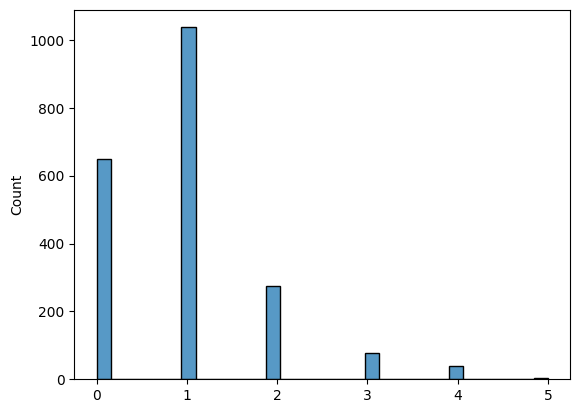

In [40]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

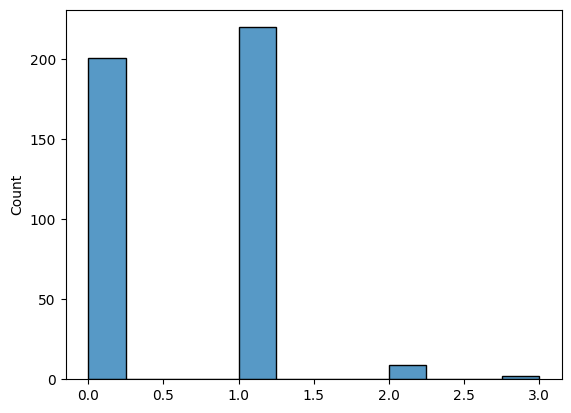

In [41]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [42]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean')#IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_val_imp = it_imp.transform(x_val)
x_test_imp = it_imp.transform(x_test)

In [43]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [44]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-24 10:59:18,079] A new study created in memory with name: no-name-7e44a467-e472-470b-8542-95e93db15812
[I 2024-11-24 10:59:22,044] Trial 0 finished with value: 0.4 and parameters: {'max_depth': 9, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4.
[I 2024-11-24 10:59:22,985] Trial 1 finished with value: 0.4294871794871794 and parameters: {'max_depth': 8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4294871794871794.
[I 2024-11-24 10:59:30,079] Trial 2 finished with value: 0.42443729903536975 and parameters: {'max_depth': 10, 'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4294871794871794.
[I 2024-11-24 10:59:32,758] Trial 3 finished with value: 0.4065573770491803 and parameters: {'max_depth': 7, 'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4294871794871794.
[I 2024-

In [45]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 2}
Best ROC-AUC score: 0.43137254901960786


In [46]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=200)

Метрики, получаемые из кросс-валидации

In [47]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([1.63340807, 1.64040542, 1.64693856, 1.67211699, 1.63186049]),
 'score_time': array([0.05482697, 0.04962921, 0.04850411, 0.04944634, 0.05024052]),
 'test_accuracy': array([0.81055156, 0.79616307, 0.80048077, 0.82211538, 0.76201923]),
 'test_precision_macro': array([0.79382378, 0.77491453, 0.79184315, 0.80135139, 0.73056924]),
 'test_recall_macro': array([0.76503818, 0.75062334, 0.73794574, 0.78936766, 0.72041703]),
 'test_f1_macro': array([0.77588729, 0.75993092, 0.75389002, 0.79470764, 0.72479234]),
 'test_roc_auc': array([0.8608384 , 0.85844891, 0.86515972, 0.88292389, 0.83198598])}

In [48]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [49]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [50]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [51]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.88      0.68       216
           1       0.70      0.30      0.42       216

    accuracy                           0.59       432
   macro avg       0.63      0.59      0.55       432
weighted avg       0.63      0.59      0.55       432

F2-score:  0.33507853403141363


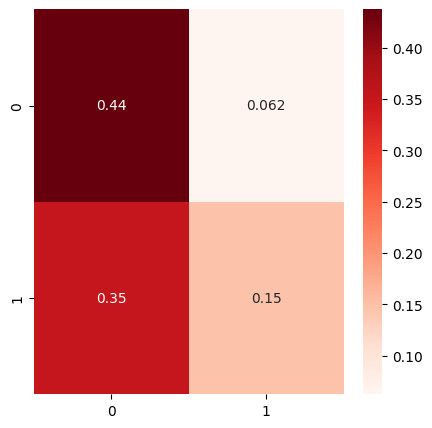

In [52]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [53]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [54]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-24 11:01:26,805] A new study created in memory with name: no-name-42e0b3a4-bbae-4b0e-b1e0-c99c54dce90b


[11:01:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:27,092] Trial 0 finished with value: 0.6084905660377359 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 0 with value: 0.6084905660377359.


[11:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:28,177] Trial 1 finished with value: 0.6266666666666667 and parameters: {'max_depth': 5, 'n_estimators': 900}. Best is trial 1 with value: 0.6266666666666667.


[11:01:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:28,656] Trial 2 finished with value: 0.6036036036036035 and parameters: {'max_depth': 8, 'n_estimators': 200}. Best is trial 1 with value: 0.6266666666666667.


[11:01:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:29,555] Trial 3 finished with value: 0.6112359550561798 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 1 with value: 0.6266666666666667.


[11:01:29] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:29,929] Trial 4 finished with value: 0.6177777777777778 and parameters: {'max_depth': 4, 'n_estimators': 400}. Best is trial 1 with value: 0.6266666666666667.


[11:01:29] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:30,719] Trial 5 finished with value: 0.6181015452538631 and parameters: {'max_depth': 6, 'n_estimators': 500}. Best is trial 1 with value: 0.6266666666666667.


[11:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:30,924] Trial 6 finished with value: 0.6036036036036035 and parameters: {'max_depth': 7, 'n_estimators': 100}. Best is trial 1 with value: 0.6266666666666667.


[11:01:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:31,386] Trial 7 finished with value: 0.6142857142857142 and parameters: {'max_depth': 3, 'n_estimators': 700}. Best is trial 1 with value: 0.6266666666666667.


[11:01:31] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:33,232] Trial 8 finished with value: 0.5945945945945946 and parameters: {'max_depth': 8, 'n_estimators': 800}. Best is trial 1 with value: 0.6266666666666667.


[11:01:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:33,431] Trial 9 finished with value: 0.625 and parameters: {'max_depth': 4, 'n_estimators': 200}. Best is trial 1 with value: 0.6266666666666667.


[11:01:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:36,444] Trial 10 finished with value: 0.581986143187067 and parameters: {'max_depth': 10, 'n_estimators': 1000}. Best is trial 1 with value: 0.6266666666666667.


[11:01:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:37,288] Trial 11 finished with value: 0.6236080178173721 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 1 with value: 0.6266666666666667.


[11:01:37] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:37,671] Trial 12 finished with value: 0.6313465783664458 and parameters: {'max_depth': 5, 'n_estimators': 300}. Best is trial 12 with value: 0.6313465783664458.


[11:01:37] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:38,149] Trial 13 finished with value: 0.6211453744493393 and parameters: {'max_depth': 6, 'n_estimators': 300}. Best is trial 12 with value: 0.6313465783664458.


[11:01:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:39,113] Trial 14 finished with value: 0.6236080178173721 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 12 with value: 0.6313465783664458.


[11:01:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:39,890] Trial 15 finished with value: 0.6252771618625277 and parameters: {'max_depth': 5, 'n_estimators': 600}. Best is trial 12 with value: 0.6313465783664458.


[11:01:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:41,615] Trial 16 finished with value: 0.6044444444444445 and parameters: {'max_depth': 7, 'n_estimators': 900}. Best is trial 12 with value: 0.6313465783664458.


[11:01:41] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:42,949] Trial 17 finished with value: 0.5812356979405033 and parameters: {'max_depth': 9, 'n_estimators': 500}. Best is trial 12 with value: 0.6313465783664458.


[11:01:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:43,431] Trial 18 finished with value: 0.6211453744493393 and parameters: {'max_depth': 6, 'n_estimators': 300}. Best is trial 12 with value: 0.6313465783664458.


[11:01:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:44,158] Trial 19 finished with value: 0.6252771618625277 and parameters: {'max_depth': 5, 'n_estimators': 600}. Best is trial 12 with value: 0.6313465783664458.


[11:01:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:44,269] Trial 20 finished with value: 0.609865470852018 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 12 with value: 0.6313465783664458.


[11:01:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:45,007] Trial 21 finished with value: 0.6252771618625277 and parameters: {'max_depth': 5, 'n_estimators': 600}. Best is trial 12 with value: 0.6313465783664458.


[11:01:45] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:45,982] Trial 22 finished with value: 0.6236080178173721 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 12 with value: 0.6313465783664458.


[11:01:45] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:46,627] Trial 23 finished with value: 0.6150442477876106 and parameters: {'max_depth': 6, 'n_estimators': 400}. Best is trial 12 with value: 0.6313465783664458.


[11:01:46] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:48,311] Trial 24 finished with value: 0.6044444444444445 and parameters: {'max_depth': 7, 'n_estimators': 900}. Best is trial 12 with value: 0.6313465783664458.


[11:01:48] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:48,789] Trial 25 finished with value: 0.6142857142857142 and parameters: {'max_depth': 3, 'n_estimators': 700}. Best is trial 12 with value: 0.6313465783664458.


[11:01:48] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:49,073] Trial 26 finished with value: 0.6160714285714285 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 12 with value: 0.6313465783664458.


[11:01:49] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:49,799] Trial 27 finished with value: 0.6252771618625277 and parameters: {'max_depth': 5, 'n_estimators': 600}. Best is trial 12 with value: 0.6313465783664458.


[11:01:49] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:51,179] Trial 28 finished with value: 0.6181015452538631 and parameters: {'max_depth': 6, 'n_estimators': 900}. Best is trial 12 with value: 0.6313465783664458.


[11:01:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 11:01:51,531] Trial 29 finished with value: 0.6099290780141844 and parameters: {'max_depth': 3, 'n_estimators': 500}. Best is trial 12 with value: 0.6313465783664458.


In [55]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 300}
Best f1 score: 0.6313465783664458


In [56]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[11:01:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=300, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [57]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[11:01:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:01:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:01:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:01:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:01:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [58]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       216
           1       0.60      0.66      0.63       216

    accuracy                           0.61       432
   macro avg       0.61      0.61      0.61       432
weighted avg       0.61      0.61      0.61       432

F2-score:  0.6494096276112625


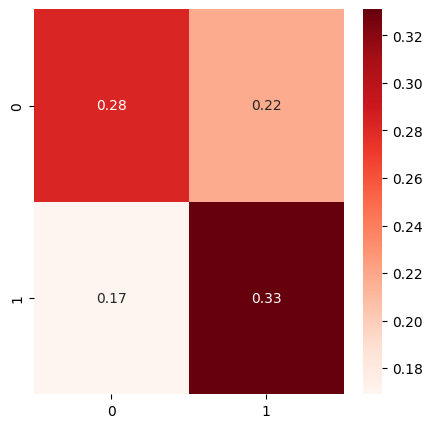

In [59]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [60]:
model = CatBoostClassifier(random_seed=42)

In [61]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.037982
0:	learn: 0.6648347	test: 0.6915095	best: 0.6915095 (0)	total: 51.7ms	remaining: 51.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6573897596
bestIteration = 96

Shrink model to first 97 iterations.


In [62]:
f1_score(y_test, model.predict(x_test_selected))

0.6048780487804879

In [63]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([ 9.17491029, 10.17866906, 11.41693889, 12.25091384,  5.6922788 ,
        2.34884027,  3.77848528, 45.15896357])

In [64]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [65]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-24 11:01:54,548] A new study created in memory with name: no-name-b0c5f51b-c6d8-408e-9711-d332e973a9ad
[I 2024-11-24 11:01:56,110] Trial 0 finished with value: 0.6004842615012107 and parameters: {'learning_rate': 0.004778687951967764, 'depth': 7, 'subsample': 0.3311135555748579, 'colsample_bylevel': 0.7483072400162215, 'min_data_in_leaf': 16, 'random_strength': 1.6081896168782497}. Best is trial 0 with value: 0.6004842615012107.
[I 2024-11-24 11:01:56,830] Trial 1 finished with value: 0.4558404558404558 and parameters: {'learning_rate': 0.0026976137946581723, 'depth': 7, 'subsample': 0.08192034236832701, 'colsample_bylevel': 0.15644391365873223, 'min_data_in_leaf': 33, 'random_strength': 1.5125490760689244}. Best is trial 0 with value: 0.6004842615012107.
[I 2024-11-24 11:01:58,839] Trial 2 finished with value: 0.5867970660146699 and parameters: {'learning_rate': 0.0011841479567559084, 'depth': 8, 'subsample': 0.5292383360604683, 'colsample_bylevel': 0.6896789780352603, 'min

In [66]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.009209263319964328, 'depth': 6, 'subsample': 0.7522829556907349, 'colsample_bylevel': 0.6482191818608021, 'min_data_in_leaf': 61, 'random_strength': 0.6601315107630612}
Best f1 score: 0.6139534883720931


In [67]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6863990	total: 1.45ms	remaining: 1.45s
1:	learn: 0.6799321	total: 2.8ms	remaining: 1.4s
2:	learn: 0.6730423	total: 4.08ms	remaining: 1.36s
3:	learn: 0.6662881	total: 5.35ms	remaining: 1.33s
4:	learn: 0.6606843	total: 6.35ms	remaining: 1.26s
5:	learn: 0.6555437	total: 7.26ms	remaining: 1.2s
6:	learn: 0.6500465	total: 8.46ms	remaining: 1.2s
7:	learn: 0.6440305	total: 9.7ms	remaining: 1.2s
8:	learn: 0.6389001	total: 10.7ms	remaining: 1.18s
9:	learn: 0.6339854	total: 11.9ms	remaining: 1.18s
10:	learn: 0.6285778	total: 13.1ms	remaining: 1.18s
11:	learn: 0.6229305	total: 14.3ms	remaining: 1.18s
12:	learn: 0.6179455	total: 15.6ms	remaining: 1.18s
13:	learn: 0.6128882	total: 16.8ms	remaining: 1.18s
14:	learn: 0.6075978	total: 18.1ms	remaining: 1.19s
15:	learn: 0.6031571	total: 19.3ms	remaining: 1.19s
16:	learn: 0.5984804	total: 20.3ms	remaining: 1.17s
17:	learn: 0.5937324	total: 21.5ms	remaining: 1.17s
18:	learn: 0.5893761	total: 22.7ms	remaining: 1.17s
19:	learn: 0.5846886	total: 

In [68]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6864470	total: 1.29ms	remaining: 1.29s
1:	learn: 0.6798491	total: 2.56ms	remaining: 1.28s
2:	learn: 0.6731527	total: 3.72ms	remaining: 1.24s
3:	learn: 0.6665119	total: 4.86ms	remaining: 1.21s
4:	learn: 0.6610807	total: 6.34ms	remaining: 1.26s
5:	learn: 0.6560064	total: 9.22ms	remaining: 1.53s
6:	learn: 0.6507222	total: 10.4ms	remaining: 1.48s
7:	learn: 0.6452956	total: 11.9ms	remaining: 1.48s
8:	learn: 0.6399148	total: 12.8ms	remaining: 1.41s
9:	learn: 0.6342442	total: 13.9ms	remaining: 1.38s
10:	learn: 0.6290924	total: 15ms	remaining: 1.35s
11:	learn: 0.6235319	total: 16.2ms	remaining: 1.33s
12:	learn: 0.6186297	total: 17.3ms	remaining: 1.32s
13:	learn: 0.6135910	total: 18.5ms	remaining: 1.3s
14:	learn: 0.6093088	total: 19.4ms	remaining: 1.27s
15:	learn: 0.6040268	total: 20.5ms	remaining: 1.26s
16:	learn: 0.5991686	total: 21.6ms	remaining: 1.25s
17:	learn: 0.5946812	total: 22.7ms	remaining: 1.24s
18:	learn: 0.5906531	total: 23.9ms	remaining: 1.23s
19:	learn: 0.5860817	tota

{'fit_time': array([1.2234478 , 1.22236753, 1.23576951, 1.23745084, 1.23292279]),
 'score_time': array([0.00832486, 0.00756621, 0.00765681, 0.00784898, 0.00823522]),
 'test_accuracy': array([0.82254197, 0.82014388, 0.83413462, 0.84134615, 0.78605769]),
 'test_precision_macro': array([0.80103668, 0.79603396, 0.81510417, 0.81853912, 0.75921979]),
 'test_recall_macro': array([0.79414056, 0.80882811, 0.80390079, 0.83713994, 0.77363106]),
 'test_f1_macro': array([0.79736013, 0.80143488, 0.80896476, 0.82587519, 0.76482395]),
 'test_roc_auc': array([0.89101865, 0.8912524 , 0.88083091, 0.89024933, 0.82821861])}

In [69]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       216
           1       0.63      0.60      0.61       216

    accuracy                           0.62       432
   macro avg       0.62      0.62      0.62       432
weighted avg       0.62      0.62      0.62       432

F2-score:  0.6028037383177569


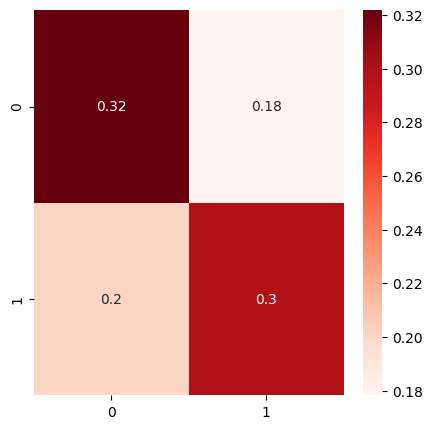

In [70]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [71]:
model = XGBClassifier()

In [72]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [73]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [74]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-24 11:03:02,598] A new study created in memory with name: no-name-2fbd740a-5e45-4b6d-8c3e-9e80fd617a23


[11:03:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:03,055] Trial 0 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 0.09352244603446393, 'max_depth': 192, 'n_estimators': 400, 'subsample': 0.1703122276314325, 'colsample_bylevel': 0.5055096639819219, 'gamma': 0.18505215041213494}. Best is trial 0 with value: 0.5454545454545454.


[11:03:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:03,385] Trial 1 finished with value: 0.5947242206235012 and parameters: {'learning_rate': 0.0046544084258791935, 'max_depth': 221, 'n_estimators': 200, 'subsample': 0.3651659434925147, 'colsample_bylevel': 0.37739071267076435, 'gamma': 2.7452462831488593}. Best is trial 1 with value: 0.5947242206235012.


[11:03:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:06,572] Trial 2 finished with value: 0.589622641509434 and parameters: {'learning_rate': 0.002638531569949507, 'max_depth': 441, 'n_estimators': 1000, 'subsample': 0.7267794985826104, 'colsample_bylevel': 0.634314276132605, 'gamma': 0.23998060451604988}. Best is trial 1 with value: 0.5947242206235012.


[11:03:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:07,424] Trial 3 finished with value: 0.5660377358490566 and parameters: {'learning_rate': 0.029942916482028407, 'max_depth': 205, 'n_estimators': 400, 'subsample': 0.4428762534449994, 'colsample_bylevel': 0.43671556772859577, 'gamma': 2.555791831243594}. Best is trial 1 with value: 0.5947242206235012.


[11:03:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:08,960] Trial 4 finished with value: 0.5904761904761905 and parameters: {'learning_rate': 0.002542868494825484, 'max_depth': 500, 'n_estimators': 700, 'subsample': 0.5032056857489955, 'colsample_bylevel': 0.5747808451874589, 'gamma': 0.20254757500091083}. Best is trial 1 with value: 0.5947242206235012.


[11:03:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:09,600] Trial 5 finished with value: 0.6211764705882353 and parameters: {'learning_rate': 0.0025047432084494008, 'max_depth': 475, 'n_estimators': 400, 'subsample': 0.29994091335385825, 'colsample_bylevel': 0.6350705671916002, 'gamma': 1.8991420950159132}. Best is trial 5 with value: 0.6211764705882353.


[11:03:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:09,909] Trial 6 finished with value: 0.583710407239819 and parameters: {'learning_rate': 0.0030684226795881326, 'max_depth': 441, 'n_estimators': 100, 'subsample': 0.8746386625915163, 'colsample_bylevel': 0.9214367311999669, 'gamma': 0.39019599918663006}. Best is trial 5 with value: 0.6211764705882353.


[11:03:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:12,768] Trial 7 finished with value: 0.5727699530516432 and parameters: {'learning_rate': 0.001649088685581819, 'max_depth': 427, 'n_estimators': 800, 'subsample': 0.937611278846734, 'colsample_bylevel': 0.8672123628309178, 'gamma': 2.3088199426986926}. Best is trial 5 with value: 0.6211764705882353.


[11:03:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:13,262] Trial 8 finished with value: 0.557544757033248 and parameters: {'learning_rate': 0.0014421872323041242, 'max_depth': 162, 'n_estimators': 500, 'subsample': 0.1935687641129643, 'colsample_bylevel': 0.34139036929467476, 'gamma': 0.6339941003404}. Best is trial 5 with value: 0.6211764705882353.


[11:03:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:14,319] Trial 9 finished with value: 0.5815602836879432 and parameters: {'learning_rate': 0.023776181193983923, 'max_depth': 345, 'n_estimators': 700, 'subsample': 0.2645126418844222, 'colsample_bylevel': 0.5529928239197256, 'gamma': 2.7449482827608245}. Best is trial 5 with value: 0.6211764705882353.


[11:03:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:14,496] Trial 10 finished with value: 0.4593023255813954 and parameters: {'learning_rate': 0.008003447310973778, 'max_depth': 310, 'n_estimators': 300, 'subsample': 0.05888769984681341, 'colsample_bylevel': 0.07913026581901578, 'gamma': 1.543740800216209}. Best is trial 5 with value: 0.6211764705882353.


[11:03:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:14,615] Trial 11 finished with value: 0.4579710144927537 and parameters: {'learning_rate': 0.005735732566542648, 'max_depth': 264, 'n_estimators': 100, 'subsample': 0.3531237463921256, 'colsample_bylevel': 0.2267326273812766, 'gamma': 1.7935319043899693}. Best is trial 5 with value: 0.6211764705882353.


[11:03:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:15,175] Trial 12 finished with value: 0.5846867749419954 and parameters: {'learning_rate': 0.005190733136248649, 'max_depth': 105, 'n_estimators': 200, 'subsample': 0.659438800991638, 'colsample_bylevel': 0.7454000163293403, 'gamma': 2.0435338209558767}. Best is trial 5 with value: 0.6211764705882353.


[11:03:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:16,094] Trial 13 finished with value: 0.5825242718446603 and parameters: {'learning_rate': 0.014817472069381938, 'max_depth': 261, 'n_estimators': 300, 'subsample': 0.5957345161958919, 'colsample_bylevel': 0.2995822713678238, 'gamma': 1.2544773891484815}. Best is trial 5 with value: 0.6211764705882353.


[11:03:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:16,982] Trial 14 finished with value: 0.6264501160092808 and parameters: {'learning_rate': 0.0010424511495227581, 'max_depth': 362, 'n_estimators': 500, 'subsample': 0.3725882186217615, 'colsample_bylevel': 0.7212447295495584, 'gamma': 2.881038899782463}. Best is trial 14 with value: 0.6264501160092808.


[11:03:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:18,000] Trial 15 finished with value: 0.6258823529411764 and parameters: {'learning_rate': 0.0010623859425810723, 'max_depth': 368, 'n_estimators': 600, 'subsample': 0.33899839292987355, 'colsample_bylevel': 0.7759505430780289, 'gamma': 1.1263627422002418}. Best is trial 14 with value: 0.6264501160092808.


[11:03:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:19,263] Trial 16 finished with value: 0.6146572104018914 and parameters: {'learning_rate': 0.001068331650177828, 'max_depth': 364, 'n_estimators': 600, 'subsample': 0.45974614009737025, 'colsample_bylevel': 0.808016752509349, 'gamma': 1.111175201901487}. Best is trial 14 with value: 0.6264501160092808.


[11:03:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:20,183] Trial 17 finished with value: 0.6208530805687204 and parameters: {'learning_rate': 0.0010559271169382786, 'max_depth': 387, 'n_estimators': 900, 'subsample': 0.15023302622905452, 'colsample_bylevel': 0.7396687390683911, 'gamma': 0.8515627890565316}. Best is trial 14 with value: 0.6264501160092808.


[11:03:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:21,805] Trial 18 finished with value: 0.5780885780885782 and parameters: {'learning_rate': 0.09544222302852051, 'max_depth': 392, 'n_estimators': 500, 'subsample': 0.7764444421768889, 'colsample_bylevel': 0.9541749443743489, 'gamma': 1.3902938934465534}. Best is trial 14 with value: 0.6264501160092808.


[11:03:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:23,233] Trial 19 finished with value: 0.591549295774648 and parameters: {'learning_rate': 0.0014884563978968502, 'max_depth': 300, 'n_estimators': 600, 'subsample': 0.5658887657383569, 'colsample_bylevel': 0.7140922738970957, 'gamma': 0.9013859073550545}. Best is trial 14 with value: 0.6264501160092808.


[11:03:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:24,760] Trial 20 finished with value: 0.5734597156398105 and parameters: {'learning_rate': 0.014036610872724432, 'max_depth': 326, 'n_estimators': 700, 'subsample': 0.39862355752269274, 'colsample_bylevel': 0.994515948529417, 'gamma': 2.997461902580507}. Best is trial 14 with value: 0.6264501160092808.


[11:03:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:25,387] Trial 21 finished with value: 0.6161137440758294 and parameters: {'learning_rate': 0.002053226128164999, 'max_depth': 491, 'n_estimators': 400, 'subsample': 0.28706900437646976, 'colsample_bylevel': 0.679259242748037, 'gamma': 1.7637311847023058}. Best is trial 14 with value: 0.6264501160092808.


[11:03:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:26,142] Trial 22 finished with value: 0.6099290780141844 and parameters: {'learning_rate': 0.0010149190117996632, 'max_depth': 416, 'n_estimators': 500, 'subsample': 0.28284931048558776, 'colsample_bylevel': 0.822176509968171, 'gamma': 2.10962265934075}. Best is trial 14 with value: 0.6264501160092808.


[11:03:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:27,180] Trial 23 finished with value: 0.5995316159250585 and parameters: {'learning_rate': 0.003700308062744815, 'max_depth': 472, 'n_estimators': 600, 'subsample': 0.32049263905303793, 'colsample_bylevel': 0.6117035606148771, 'gamma': 1.7886094964052488}. Best is trial 14 with value: 0.6264501160092808.


[11:03:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:27,573] Trial 24 finished with value: 0.5966587112171838 and parameters: {'learning_rate': 0.0019236126584302575, 'max_depth': 366, 'n_estimators': 300, 'subsample': 0.2144346889076899, 'colsample_bylevel': 0.5032516069121323, 'gamma': 2.3893675346428718}. Best is trial 14 with value: 0.6264501160092808.


[11:03:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:27,937] Trial 25 finished with value: 0.616867469879518 and parameters: {'learning_rate': 0.0013947922917515133, 'max_depth': 271, 'n_estimators': 400, 'subsample': 0.09868310793397667, 'colsample_bylevel': 0.7752439296549479, 'gamma': 1.0610750019111268}. Best is trial 14 with value: 0.6264501160092808.


[11:03:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:29,602] Trial 26 finished with value: 0.5868544600938966 and parameters: {'learning_rate': 0.0022096533479507323, 'max_depth': 461, 'n_estimators': 800, 'subsample': 0.4356769001920281, 'colsample_bylevel': 0.6789034481187491, 'gamma': 0.6312211801108052}. Best is trial 14 with value: 0.6264501160092808.


[11:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:30,348] Trial 27 finished with value: 0.6066350710900473 and parameters: {'learning_rate': 0.0033339572502228097, 'max_depth': 407, 'n_estimators': 500, 'subsample': 0.24033076622497274, 'colsample_bylevel': 0.8492388111670154, 'gamma': 2.0358323516544026}. Best is trial 14 with value: 0.6264501160092808.


[11:03:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:31,798] Trial 28 finished with value: 0.5829383886255923 and parameters: {'learning_rate': 0.0013006162937803756, 'max_depth': 340, 'n_estimators': 600, 'subsample': 0.5116872658243514, 'colsample_bylevel': 0.8940649336197224, 'gamma': 1.403934638500114}. Best is trial 14 with value: 0.6264501160092808.


[11:03:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:32,282] Trial 29 finished with value: 0.5995203836930455 and parameters: {'learning_rate': 0.00809114145243143, 'max_depth': 372, 'n_estimators': 400, 'subsample': 0.16960453076806797, 'colsample_bylevel': 0.5282970150827656, 'gamma': 2.264420867941762}. Best is trial 14 with value: 0.6264501160092808.


In [75]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0010424511495227581, 'max_depth': 362, 'n_estimators': 500, 'subsample': 0.3725882186217615, 'colsample_bylevel': 0.7212447295495584, 'gamma': 2.881038899782463}
Best f1 score: 0.6264501160092808


In [76]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[11:03:32] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7212447295495584, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.881038899782463, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0010424511495227581, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=362, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [77]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[11:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:03:35] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:03:36] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([0.69688606, 0.69896483, 0.70061684, 0.6897521 , 0.6885047 ]),
 'score_time': array([0.01443291, 0.01353717, 0.01319718, 0.01330853, 0.01366591]),
 'test_accuracy': array([0.83932854, 0.82494005, 0.83653846, 0.83173077, 0.77163462]),
 'test_precision_macro': array([0.81834532, 0.80122458, 0.81609501, 0.8086533 , 0.74293233]),
 'test_recall_macro': array([0.81950288, 0.81241234, 0.81126547, 0.82997148, 0.75359077]),
 'test_f1_macro': array([0.81891775, 0.80609469, 0.81357585, 0.81645825, 0.74733881]),
 'test_roc_auc': array([0.90208301, 0.88299309, 0.88674358, 0.89153128, 0.82685817])}

In [78]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       216
           1       0.63      0.62      0.63       216

    accuracy                           0.63       432
   macro avg       0.63      0.63      0.63       432
weighted avg       0.63      0.63      0.63       432

F2-score:  0.6255792400370714


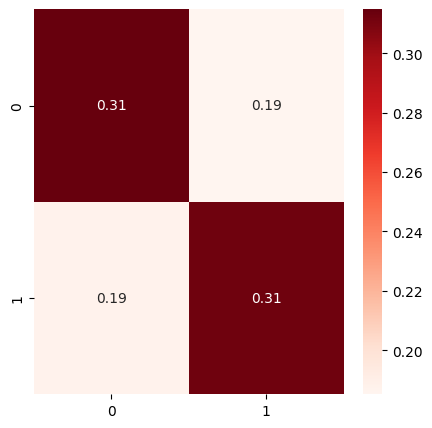

In [79]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [80]:
model = LGBMClassifier()

In [81]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [82]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [83]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-24 11:03:37,178] A new study created in memory with name: no-name-bae28fc6-11e3-45a2-bb14-58388b108087


[11:03:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:38,920] Trial 0 finished with value: 0.5714285714285713 and parameters: {'learning_rate': 0.0831462983573986, 'max_depth': 499, 'n_estimators': 700, 'subsample': 0.6409888959957886, 'colsample_bylevel': 0.8321515282507103, 'gamma': 1.0285288444195257}. Best is trial 0 with value: 0.5714285714285713.


[11:03:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:39,192] Trial 1 finished with value: 0.5536159600997506 and parameters: {'learning_rate': 0.015743622553200387, 'max_depth': 448, 'n_estimators': 200, 'subsample': 0.221633592413101, 'colsample_bylevel': 0.43109770619529675, 'gamma': 2.973651272378369}. Best is trial 0 with value: 0.5714285714285713.


[11:03:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:40,952] Trial 2 finished with value: 0.5913461538461537 and parameters: {'learning_rate': 0.0026242073927746482, 'max_depth': 201, 'n_estimators': 800, 'subsample': 0.7302434420495602, 'colsample_bylevel': 0.37083220930170324, 'gamma': 2.7418334859539497}. Best is trial 2 with value: 0.5913461538461537.


[11:03:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:41,161] Trial 3 finished with value: 0.6014319809069213 and parameters: {'learning_rate': 0.004220915273843332, 'max_depth': 406, 'n_estimators': 100, 'subsample': 0.8346208162895866, 'colsample_bylevel': 0.3231488212468947, 'gamma': 1.5544768500954023}. Best is trial 3 with value: 0.6014319809069213.


[11:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:41,805] Trial 4 finished with value: 0.6062052505966588 and parameters: {'learning_rate': 0.0016016173378761182, 'max_depth': 219, 'n_estimators': 800, 'subsample': 0.0884511304948298, 'colsample_bylevel': 0.843936664617778, 'gamma': 1.4633741946380678}. Best is trial 4 with value: 0.6062052505966588.


[11:03:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:42,690] Trial 5 finished with value: 0.5876543209876544 and parameters: {'learning_rate': 0.02095718790867867, 'max_depth': 169, 'n_estimators': 800, 'subsample': 0.7261282007431158, 'colsample_bylevel': 0.19922602881932366, 'gamma': 2.8565701137928077}. Best is trial 4 with value: 0.6062052505966588.


[11:03:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:42,826] Trial 6 finished with value: 0.5931372549019609 and parameters: {'learning_rate': 0.060511565500226454, 'max_depth': 280, 'n_estimators': 100, 'subsample': 0.4604182047062078, 'colsample_bylevel': 0.1763600350619216, 'gamma': 0.8652290052212015}. Best is trial 4 with value: 0.6062052505966588.


[11:03:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:44,063] Trial 7 finished with value: 0.5865384615384615 and parameters: {'learning_rate': 0.008522777905963407, 'max_depth': 349, 'n_estimators': 500, 'subsample': 0.7583841663052598, 'colsample_bylevel': 0.33624046469468793, 'gamma': 1.920943574343109}. Best is trial 4 with value: 0.6062052505966588.


[11:03:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:44,409] Trial 8 finished with value: 0.5852534562211981 and parameters: {'learning_rate': 0.010845757413647874, 'max_depth': 169, 'n_estimators': 100, 'subsample': 0.8903878545036708, 'colsample_bylevel': 0.854319409414549, 'gamma': 1.0201764273616247}. Best is trial 4 with value: 0.6062052505966588.


[11:03:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:46,780] Trial 9 finished with value: 0.5871121718377088 and parameters: {'learning_rate': 0.009396270514978105, 'max_depth': 352, 'n_estimators': 800, 'subsample': 0.9517261932320897, 'colsample_bylevel': 0.29532107818585085, 'gamma': 2.875147373389574}. Best is trial 4 with value: 0.6062052505966588.


[11:03:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:47,638] Trial 10 finished with value: 0.5916870415647922 and parameters: {'learning_rate': 0.0010475366178175646, 'max_depth': 258, 'n_estimators': 1000, 'subsample': 0.10377689885386596, 'colsample_bylevel': 0.6416349637311602, 'gamma': 0.15457350952630367}. Best is trial 4 with value: 0.6062052505966588.


[11:03:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:48,316] Trial 11 finished with value: 0.6037735849056604 and parameters: {'learning_rate': 0.0027750240422255113, 'max_depth': 103, 'n_estimators': 400, 'subsample': 0.3397627257404823, 'colsample_bylevel': 0.5786916946859862, 'gamma': 1.7656610069881389}. Best is trial 4 with value: 0.6062052505966588.


[11:03:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:48,982] Trial 12 finished with value: 0.6074766355140186 and parameters: {'learning_rate': 0.0010616493838575649, 'max_depth': 100, 'n_estimators': 400, 'subsample': 0.3402989322123474, 'colsample_bylevel': 0.6536151797845485, 'gamma': 2.210261620205876}. Best is trial 12 with value: 0.6074766355140186.


[11:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:49,284] Trial 13 finished with value: 0.5620253164556962 and parameters: {'learning_rate': 0.0011196691043163865, 'max_depth': 111, 'n_estimators': 400, 'subsample': 0.06357136728265174, 'colsample_bylevel': 0.9998270588850444, 'gamma': 2.1991278088004282}. Best is trial 12 with value: 0.6074766355140186.


[11:03:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:50,273] Trial 14 finished with value: 0.6052009456264775 and parameters: {'learning_rate': 0.001714900651335307, 'max_depth': 228, 'n_estimators': 600, 'subsample': 0.2976191391069201, 'colsample_bylevel': 0.7178449060978906, 'gamma': 2.3516364107420666}. Best is trial 12 with value: 0.6074766355140186.


[11:03:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:52,763] Trial 15 finished with value: 0.588235294117647 and parameters: {'learning_rate': 0.0037738594911475147, 'max_depth': 151, 'n_estimators': 1000, 'subsample': 0.47791576920905576, 'colsample_bylevel': 0.78463491378705, 'gamma': 1.3501636371340964}. Best is trial 12 with value: 0.6074766355140186.


[11:03:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:53,140] Trial 16 finished with value: 0.5985401459854014 and parameters: {'learning_rate': 0.0018964194064674243, 'max_depth': 313, 'n_estimators': 300, 'subsample': 0.18180884852281168, 'colsample_bylevel': 0.9975260379169892, 'gamma': 2.235353320577548}. Best is trial 12 with value: 0.6074766355140186.


[11:03:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:54,255] Trial 17 finished with value: 0.5901639344262295 and parameters: {'learning_rate': 0.0044485924486904905, 'max_depth': 218, 'n_estimators': 600, 'subsample': 0.34680742120394425, 'colsample_bylevel': 0.527833275428722, 'gamma': 0.592448243796263}. Best is trial 12 with value: 0.6074766355140186.


[11:03:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:56,634] Trial 18 finished with value: 0.5995316159250585 and parameters: {'learning_rate': 0.0017940025973430045, 'max_depth': 138, 'n_estimators': 900, 'subsample': 0.5835406063603907, 'colsample_bylevel': 0.6947511702411836, 'gamma': 1.4146786187027607}. Best is trial 12 with value: 0.6074766355140186.


[11:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:57,223] Trial 19 finished with value: 0.6099290780141844 and parameters: {'learning_rate': 0.0010507805860913357, 'max_depth': 195, 'n_estimators': 500, 'subsample': 0.17410815362745855, 'colsample_bylevel': 0.8997724947948219, 'gamma': 2.4570955654271405}. Best is trial 19 with value: 0.6099290780141844.


[11:03:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:58,168] Trial 20 finished with value: 0.6004618937644342 and parameters: {'learning_rate': 0.03494196963575521, 'max_depth': 179, 'n_estimators': 400, 'subsample': 0.41439665125160313, 'colsample_bylevel': 0.9141707274744226, 'gamma': 2.3404763847931243}. Best is trial 19 with value: 0.6099290780141844.


[11:03:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:58,773] Trial 21 finished with value: 0.6117647058823529 and parameters: {'learning_rate': 0.0010909131282101619, 'max_depth': 246, 'n_estimators': 500, 'subsample': 0.1849098714866211, 'colsample_bylevel': 0.7365080891859075, 'gamma': 1.9540701897517834}. Best is trial 21 with value: 0.6117647058823529.


[11:03:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:59,472] Trial 22 finished with value: 0.6009389671361502 and parameters: {'learning_rate': 0.0011539936908102188, 'max_depth': 250, 'n_estimators': 500, 'subsample': 0.24877065346263738, 'colsample_bylevel': 0.7476317596341759, 'gamma': 2.550991139358052}. Best is trial 21 with value: 0.6117647058823529.


[11:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:03:59,877] Trial 23 finished with value: 0.6139088729016786 and parameters: {'learning_rate': 0.005948678823433664, 'max_depth': 303, 'n_estimators': 300, 'subsample': 0.18776584719456066, 'colsample_bylevel': 0.6285696875298828, 'gamma': 1.9672963364334397}. Best is trial 23 with value: 0.6139088729016786.


[11:03:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:04:00,227] Trial 24 finished with value: 0.6034063260340633 and parameters: {'learning_rate': 0.0071396043849457, 'max_depth': 313, 'n_estimators': 300, 'subsample': 0.1466163189881694, 'colsample_bylevel': 0.5878054601734547, 'gamma': 1.7899255921276622}. Best is trial 23 with value: 0.6139088729016786.


[11:04:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:04:00,708] Trial 25 finished with value: 0.5957446808510638 and parameters: {'learning_rate': 0.005861654957736669, 'max_depth': 282, 'n_estimators': 300, 'subsample': 0.2504610679405577, 'colsample_bylevel': 0.9139797021251015, 'gamma': 1.9374301769845}. Best is trial 23 with value: 0.6139088729016786.


[11:04:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:04:01,272] Trial 26 finished with value: 0.5931372549019609 and parameters: {'learning_rate': 0.0030311937924364543, 'max_depth': 345, 'n_estimators': 500, 'subsample': 0.16382011736736096, 'colsample_bylevel': 0.4811870554952766, 'gamma': 2.493538729683039}. Best is trial 23 with value: 0.6139088729016786.


[11:04:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:04:01,953] Trial 27 finished with value: 0.5727923627684965 and parameters: {'learning_rate': 0.032599168621965595, 'max_depth': 390, 'n_estimators': 600, 'subsample': 0.1418134349628971, 'colsample_bylevel': 0.7738680087297614, 'gamma': 2.0609615982290452}. Best is trial 23 with value: 0.6139088729016786.


[11:04:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:04:02,369] Trial 28 finished with value: 0.5990338164251209 and parameters: {'learning_rate': 0.002291966948451583, 'max_depth': 250, 'n_estimators': 200, 'subsample': 0.41577746521392445, 'colsample_bylevel': 0.6374111457746577, 'gamma': 2.585129903598858}. Best is trial 23 with value: 0.6139088729016786.


[11:04:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 11:04:04,401] Trial 29 finished with value: 0.5733944954128439 and parameters: {'learning_rate': 0.01465574246658988, 'max_depth': 284, 'n_estimators': 700, 'subsample': 0.5615821701862119, 'colsample_bylevel': 0.9289834376370127, 'gamma': 1.6643370192776816}. Best is trial 23 with value: 0.6139088729016786.


In [84]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.005948678823433664, 'max_depth': 303, 'n_estimators': 300, 'subsample': 0.18776584719456066, 'colsample_bylevel': 0.6285696875298828, 'gamma': 1.9672963364334397}
Best f1 score: 0.6139088729016786


In [85]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.005948678823433664, max_depth=303,
               n_estimators=300, random_seed=42, subsample=0.18776584719456066)

In [86]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.19536471, 0.19321108, 0.19325399, 0.19167614, 0.18355775]),
 'score_time': array([0.0115366 , 0.01068711, 0.0108273 , 0.01090479, 0.01114488]),
 'test_accuracy': array([0.84172662, 0.80815348, 0.82932692, 0.82692308, 0.77403846]),
 'test_precision_macro': array([0.8208097 , 0.78338788, 0.80874126, 0.80409701, 0.74423776]),
 'test_recall_macro': array([0.82312607, 0.78338788, 0.80031656, 0.80409701, 0.74423776]),
 'test_f1_macro': array([0.82194245, 0.78338788, 0.80420934, 0.80409701, 0.74423776]),
 'test_roc_auc': array([0.88582411, 0.87678562, 0.87690657, 0.88420584, 0.82267221])}

In [87]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       216
           1       0.61      0.54      0.57       216

    accuracy                           0.60       432
   macro avg       0.60      0.60      0.60       432
weighted avg       0.60      0.60      0.60       432

F2-score:  0.5539772727272727


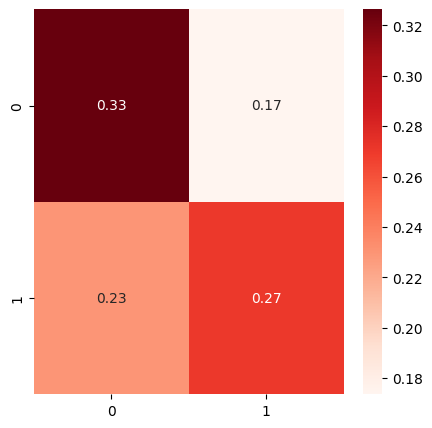

In [88]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [89]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [90]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [91]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [92]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.8 +- 0.02 , 'AUC': 0.86 +- 0.02 ,'Precision': 0.78 +- 0.03 ,'Recall': 0.75 +- 0.02 ,'F1-score': 0.76 +- 0.02 ,'F2-score': 0.76 +- 0.02
'Accuracy': 0.82 +- 0.02 , 'AUC': 0.88 +- 0.02 ,'Precision': 0.8 +- 0.03 ,'Recall': 0.81 +- 0.03 ,'F1-score': 0.81 +- 0.03 ,'F2-score': 0.81 +- 0.03
'Accuracy': 0.82 +- 0.03 , 'AUC': 0.88 +- 0.03 ,'Precision': 0.8 +- 0.03 ,'Recall': 0.81 +- 0.03 ,'F1-score': 0.8 +- 0.03 ,'F2-score': 0.8 +- 0.03
'Accuracy': 0.82 +- 0.02 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.79 +- 0.03 ,'Recall': 0.79 +- 0.03 ,'F1-score': 0.79 +- 0.03 ,'F2-score': 0.79 +- 0.03
'Accuracy': 0.82 +- 0.02 , 'AUC': 0.88 +- 0.02 ,'Precision': 0.8 +- 0.02 ,'Recall': 0.8 +- 0.02 ,'F1-score': 0.8 +- 0.02 ,'F2-score': 0.8 +- 0.02


In [93]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_val_imp, y_val))
  else: print(test_results(model, x_val_selected, y_val))

{'Accuracy': 0.83, 'AUC': 0.76, 'Precision': 0.79, 'Recall': 0.59, 'F1-score': 0.68, 'F2-score': 0.62}
{'Accuracy': 0.81, 'AUC': 0.78, 'Precision': 0.66, 'Recall': 0.71, 'F1-score': 0.69, 'F2-score': 0.7}
{'Accuracy': 0.83, 'AUC': 0.79, 'Precision': 0.71, 'Recall': 0.69, 'F1-score': 0.7, 'F2-score': 0.7}
{'Accuracy': 0.8, 'AUC': 0.75, 'Precision': 0.66, 'Recall': 0.64, 'F1-score': 0.65, 'F2-score': 0.64}
{'Accuracy': 0.81, 'AUC': 0.77, 'Precision': 0.68, 'Recall': 0.67, 'F1-score': 0.67, 'F2-score': 0.67}


In [94]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.7, 'Recall': 0.3, 'F1-score': 0.42, 'F2-score': 0.34}
{'Accuracy': 0.61, 'AUC': 0.61, 'Precision': 0.6, 'Recall': 0.66, 'F1-score': 0.63, 'F2-score': 0.65}
{'Accuracy': 0.63, 'AUC': 0.63, 'Precision': 0.63, 'Recall': 0.62, 'F1-score': 0.63, 'F2-score': 0.63}
{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.61, 'Recall': 0.54, 'F1-score': 0.57, 'F2-score': 0.55}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.63, 'Recall': 0.6, 'F1-score': 0.61, 'F2-score': 0.6}


In [95]:
import shap
shap.initjs()

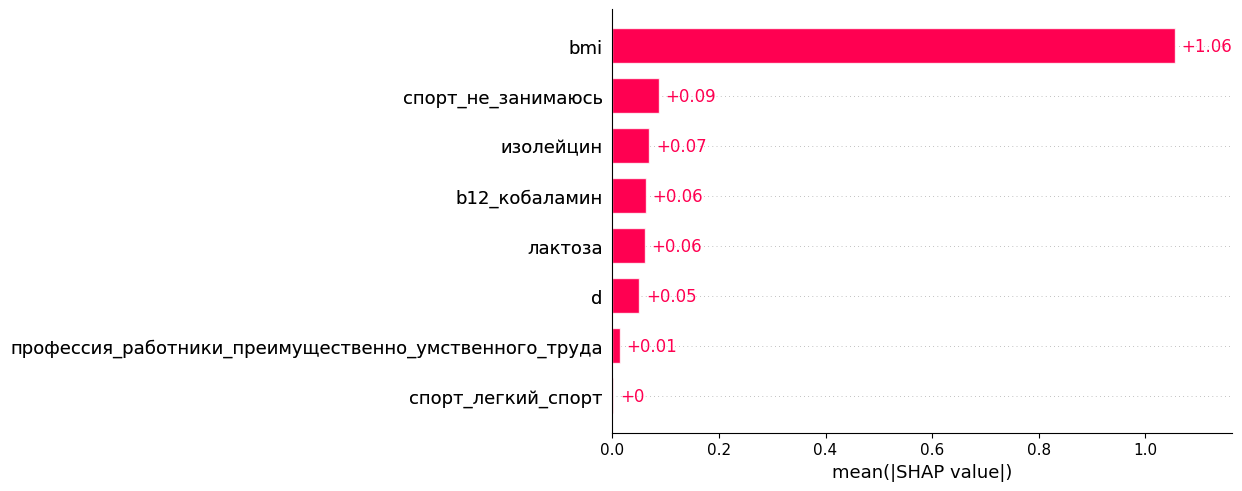

In [96]:
explainer = shap.TreeExplainer(xgb_rfc_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor

In [98]:
estimator = Pipeline([("imputer", IterativeImputer(missing_values=np.nan)),
                      ("boosting", xgb_best)])

scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(estimator, x_train_selected, y_train, scoring=scoring)


metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
imputer_metrics = []
for metric in metrics: imputer_metrics.append(scores[metric])
imputer_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
imputer_metrics = np.array(imputer_metrics)

print("'Accuracy':", round(np.mean(imputer_metrics[0]), round_num),"+-",round(np.std(imputer_metrics[0]), round_num),",",
        "'AUC':", round(np.mean(imputer_metrics[1]), round_num),"+-",round(np.std(imputer_metrics[1]), round_num),","
        "'Precision':", round(np.mean(imputer_metrics[2]), round_num),"+-",round(np.std(imputer_metrics[2]), round_num),","
        "'Recall':", round(np.mean(imputer_metrics[3]), round_num),"+-",round(np.std(imputer_metrics[3]), round_num),","
        "'F1-score':", round(np.mean(imputer_metrics[4]), round_num),"+-",round(np.std(imputer_metrics[4]), round_num),","
        "'F2-score':", round(np.mean(imputer_metrics[5]), round_num),"+-",round(np.std(imputer_metrics[5]), round_num),)

[11:04:10] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:04:11] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:04:12] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:04:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:04:14] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

'Accuracy': 0.8 +- 0.03 , 'AUC': 0.86 +- 0.02 ,'Precision': 0.78 +- 0.03 ,'Recall': 0.77 +- 0.03 ,'F1-score': 0.77 +- 0.03 ,'F2-score': 0.77 +- 0.03


In [99]:
file_names = ["RFClassifier.txt","XGBRFClassifier.txt","XGBoostClassifier.txt","LightGBMClassifier.txt","CatBoostClassifier.txt"]
for i in range(len(best_models)):
    file = open(file_names[i], "w")
    file.write(str(best_models[i].feature_importances_))
    file.close()